# Submission Information:

### Team Member 1:
* UNI: aj2713 
* Name: Aarshay Jain

# Step0 - Import Libraries, Load Data [0 points]

This is the basic step where you can load the data and create train and test sets for internal validation as per your convinience.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rcParams = plt.rcParams.copy()
import seaborn as sns
plt.rcParams = rcParams
% matplotlib inline
plt.rcParams["figure.dpi"] = 100
np.set_printoptions(precision=3, suppress=True)
plt.style.use(['fivethirtyeight'])

In [2]:
train = pd.read_csv('final_data/data.csv')
holdout = pd.read_csv('final_data/holdout.csv')

#You were not provided this dataset. but I'll use this as a proxy for leaderboard performance.
hold_sol = pd.read_csv('final_data/holdout_solutions.csv')

In [3]:
#check the shape of train
train.shape

(32950, 21)

In [4]:
#drop duration from train and holdout:
train.drop('duration',axis=1,inplace=True)
holdout.drop('duration',axis=1,inplace=True)

In [5]:
#check the columns and mark the ones which are numeric or categorical:
train.columns

Index(['age', 'job', 'marital_status', 'education', 'credit_default',
       'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign',
       'prev_days', 'prev_contacts', 'prev_outcomes', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'subscribed'],
      dtype='object')

In [6]:
#mark categorical, numeric and target variables:
target = 'subscribed'
categorical_vars = ['job', 'marital_status', 'education', 'credit_default', 'housing', 'loan',
                    'contact', 'month', 'day_of_week', 'prev_outcomes']
numeric_vars = [x for x in train.columns if x not in categorical_vars+[target]]

# Step1 - Exploration and Preparation [10 points]

In this step, I will perform the following actions:
* check the imbalance in data
* check missing values
* understand the data better using plots
* Perform basic feature engineering which will be used accross all model sets.
* make some hypothesis using the plots and try to make some features representing them. Note that these features might/might not work because they are just hypothesis. 

### 1.0 Load libraries required for this step.

### 1.1 Check Imbalance
This shows that ~89% of the data belong to a single class, which is a significant imbalance. This also tells me that the most basic model will also perform well and I need to be careful when deciding whether a model is good or bad.

In [7]:
train['subscribed'].value_counts()/train.shape[0]

no     0.887344
yes    0.112656
Name: subscribed, dtype: float64

In [8]:
#I can see that the labels are no or yes so its a good idea to convert them into numbers:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train['subscribed'] = le.fit_transform(train['subscribed'])
train['subscribed'].value_counts()/train.shape[0]

0    0.887344
1    0.112656
Name: subscribed, dtype: float64

This confirms that no are coded as 0s and yes are coded as 1s

### 1.2 Check missing values
From the data dictioanry, we know that some values are encoded as "unknown". So we'll check for both nan and unknown values. Also I'll add a column for number of unique values because that'll be interesting to know.

In [9]:
pd.concat([train.apply(lambda x: sum(x.isnull())).rename("num_missing"),
          train.apply(lambda x: sum(x=="unknown")).rename("num_unkowns"),
          train.apply(lambda x: len(np.unique(x))).rename("num_unique")],axis=1)

,num_missing,num_unkowns,num_unique
age,0,0,78
job,0,261,12
marital_status,0,63,4
education,0,1394,8
credit_default,0,6888,3
housing,0,800,3
loan,0,800,3
contact,0,0,2
month,0,0,10
day_of_week,0,0,5


There are no missing values but some unknowns in categorical features. We can create new one-hot-encoded features or impute them depending on the distribution of each variable which we'll see next. You should also notice that some of the numeric  features have few unique values which we'll inpect later.

### 1.3 Visualizing categorical variables:
Here I'll be looking at 2 things in every feature which should drive feature engineering decisions:
1. The count of each category - will affect imputation
2. The mean outcome for each category - will derive creating new features

In [10]:
#create a function which makes the plot:
def visualize_categorical(ax1, ax2, df, col, target):
    #plot counts:
    cnt = df[col].value_counts().sort_values(ascending=False)
    cnt.plot(kind='barh',ax=ax1)
    ax1.invert_yaxis()  # labels read top-to-bottom
    ax1.set_xlabel('Count')
    
    #plot means:
    means = df.groupby(col)[target].mean()
    means[cnt.index].plot(kind='barh',ax=ax2)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.axvline(x=0.112656, linewidth=1, color='red', linestyle='--') #baseline 
    ax2.set_xlabel('Percentage Subscribed')

We'll can now print all of them at one go and analyze them individually. Note that the red line is the baseline percentage in that data.

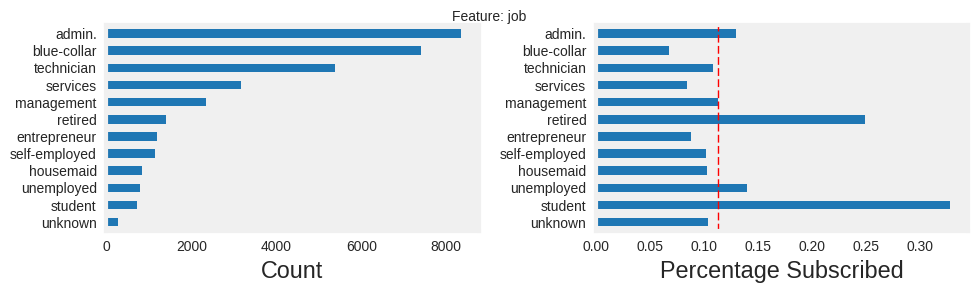

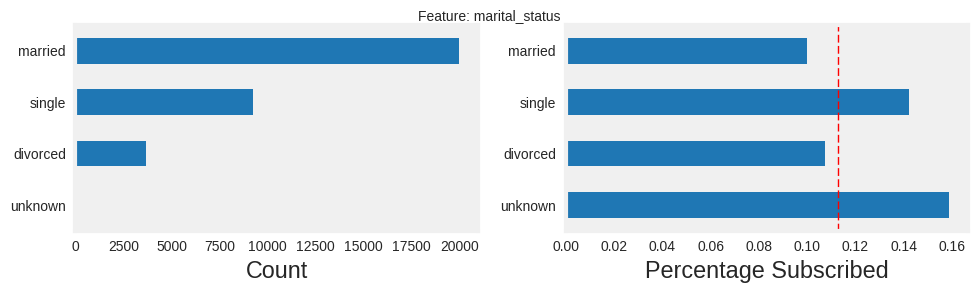

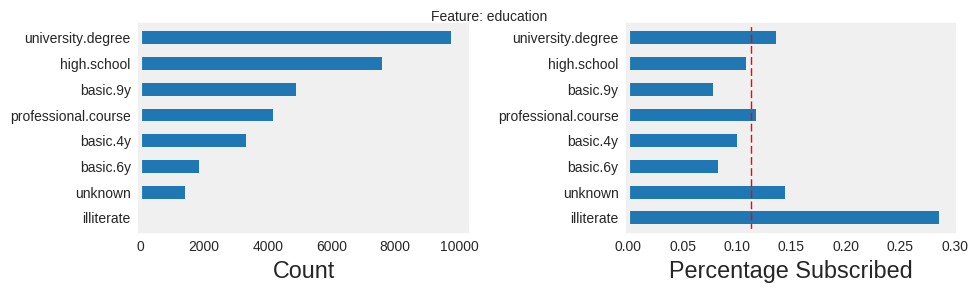

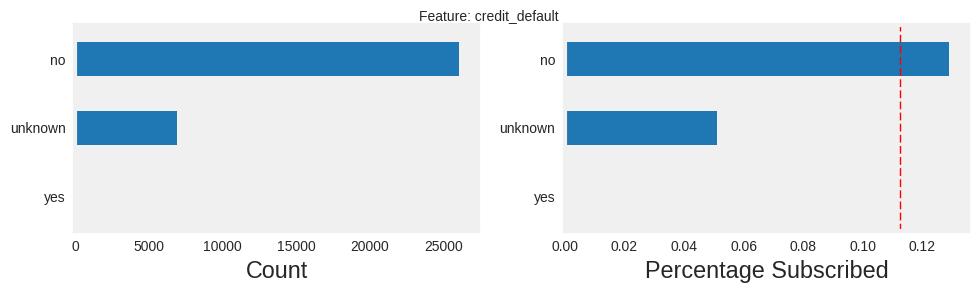

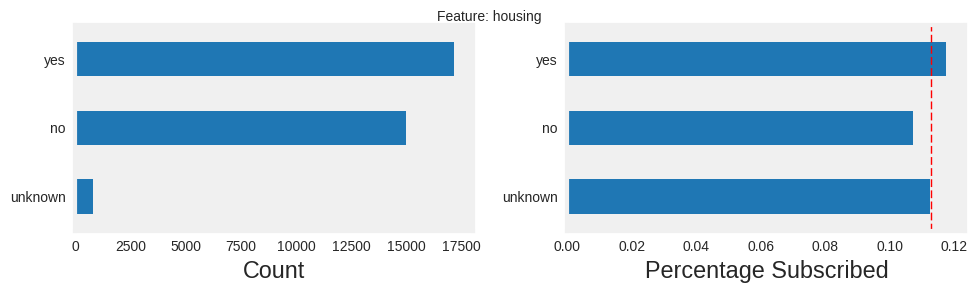

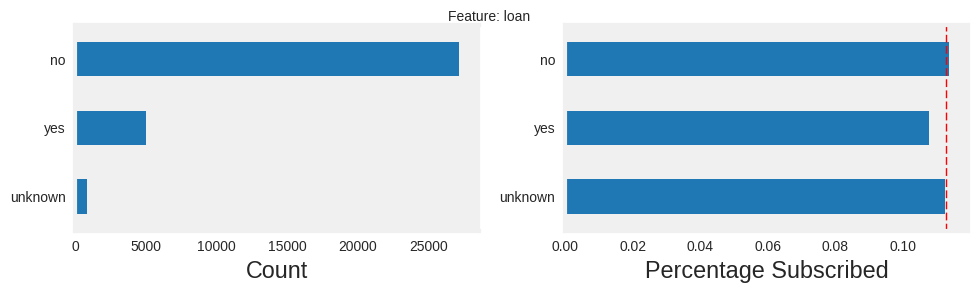

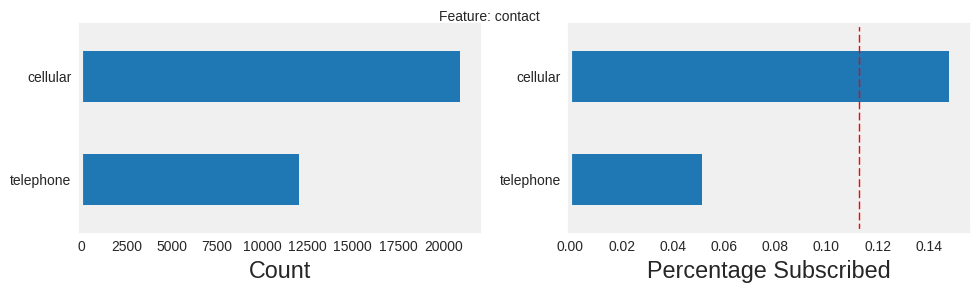

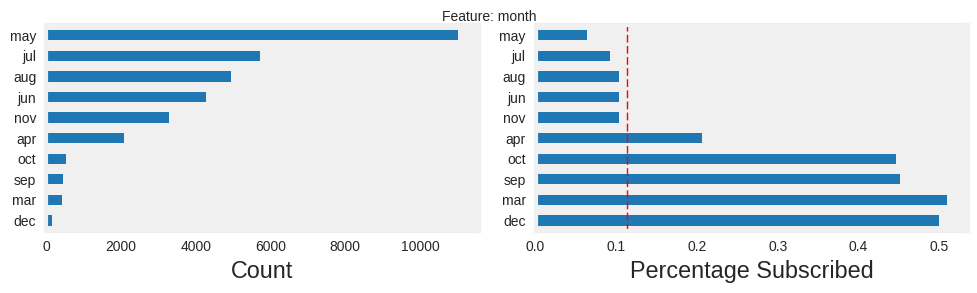

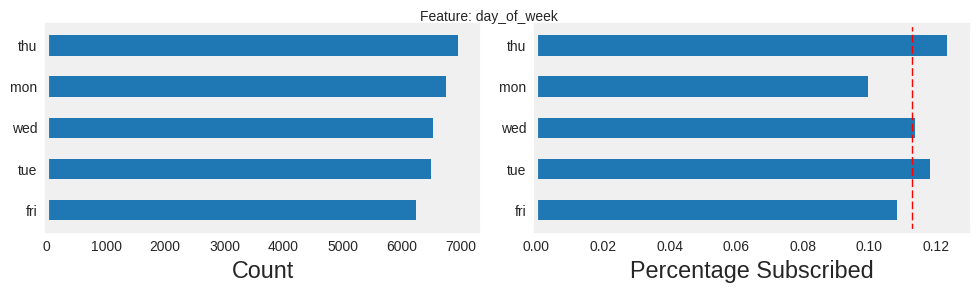

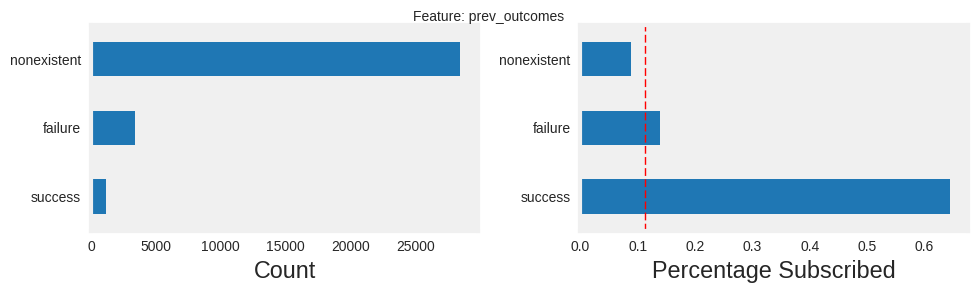

In [11]:
for col in categorical_vars:
    fig, axes = plt.subplots(1, 2,figsize=(10,3))
    ax11 = plt.subplot(1, 2, 1)
    ax21 = plt.subplot(1, 2, 2)
    fig.suptitle('Feature: %s'%col,fontsize=10)
    visualize_categorical(ax11,ax21,train,col,target)
    plt.tight_layout()

Some feature specific inferences:
1. job:
    * very few unknown values - impute them as admin, the most prominent class
    * Intuitively one could imagine that someone who's currently earning money vs someon who's not should be a good faeture. This can also be seen from the data where the means for student and retired is very different. It being high might be counter-intuitive but thats what the data tells us.
    
2. marital_status:
    * very few unknown values - impute them as married, the most prominent class
    * the high mean of unknown is just by chance and should not be considered 
    * Whether someone was married at some point or not might be a proxy for some aspects of the individual not present in the data. We can also see that the mean for single and others is somewhat different.

3. education:
    * unknowns are a decent number - will make a different category
    * Intuitively, differentiating between illetrate or someong with 4 or 6 or even 9 years of education for whether they would buy a term deposit doesn't make much sense. The high percentage of illetrate is again not trustworthy because the #samples are too less. There is no hard and fast rule to which ones should be combined, but I'll combine illetrate, 4y and 6y as a single category.

4. credit_default:
    * unknowns are a decent number - will make a different category
    * though yes are too few, its somewhat how things practially are, so I'll leave it as it is
    
5. housing:
    * unknowns are a decent number - will make a different category
    * nothing much to do otherwise
    
6. loan:
    * unknowns are a decent number - will make a different category
    * nothing much to do otherwise
    
7. month:
    * This probably tells us something about the data collection process. It started slow in Mar slowly picked up and then went down. So maybe we can create a feature which divides the 10 months into 2 depending on the phase of data collection:
        * 0: Mar, Apr, May, Jun, Jul
        * 1: Aug, Sep, Oct, Nov, Dec

General Inferences:
    * For high cardinality columns (ones with high #categories), we can create count feature. These would be job, education, month, day_of_week
    * We need to think about which model would benefit from these features so they might not be ideal for all models
        * Just interactions (basically linear combinations) of the different features are not expected to help for linear models as we're creating a low-rank matrix. But for tree-based methods, they might work out well because it'll augment the tree splits as the tree will be able to make the split in one go.
        * Count features may work for all types of models.
    * We'll one-hot-encode all features

In [12]:
#create count features:
for col in ['job', 'education','month', 'day_of_week']:
    counts = train[col].value_counts()
    train = train.merge(pd.DataFrame(counts).rename(columns={col:'%s_count'%col}),
                     left_on=col,right_index=True,how='left')
    holdout = holdout.merge(pd.DataFrame(counts).rename(columns={col:'%s_count'%col}),
                     left_on=col,right_index=True,how='left')

In [13]:
#update numeric cols:
numeric_vars = [x for x in train.columns if x not in categorical_vars+[target]]

We'll now impute the unknowns for the job and marital_status. We can use some techniques which make use of other features like fancyimpute, but i'll just use the most_frequent value here because the number of unknowns are not much.

Note that sklearn's imputer works with only numeric input so we'll just use pandas [replace](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) function here.

In [14]:
imp_vals = {'job':{'unknown':'admin.'},
            'marital_status':{'unknown':'married'}}
train.replace(imp_vals,inplace=True)
holdout.replace(imp_vals,inplace=True)

Now we'll one-hot-encode variables. We'll use pandas get_dummies for this. Note that since we'll be doing it independently on train and test set, we should drop categories which are not present in both the datasets.

In [15]:
#create dummies:
train = pd.get_dummies(train,columns=categorical_vars)
holdout = pd.get_dummies(holdout,columns=categorical_vars)

In [16]:
#check columns in train but not in holdout [except for target]:
col_to_remove = set(train.columns).difference(set(holdout.columns).union(set([target])))
#drop from train:
if col_to_remove:
    train.drop(col_to_remove,axis=1,inplace=True)

In [17]:
train.columns

Index(['age', 'campaign', 'prev_days', 'prev_contacts', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'subscribed', 'job_count', 'education_count', 'month_count',
       'day_of_week_count', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_status_divorced', 'marital_status_married',
       'marital_status_single', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'credit_default_no', 'credit_default_unknown',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_ju

### 1.4 Visualize Numeric Features:
We'll make 2 plots to visualize these features:
1. histogram
2. box-whiskers plot with the outcome
3. counts of top 10 most occuring unique values to see if there are any dominating ones

In [18]:
#create a function which makes the plot:
from matplotlib.ticker import FormatStrFormatter
def visualize_numeric(ax1, ax2, ax3, df, col, target):
    #plot histogram:
    df.hist(column=col,ax=ax1,bins=30)
    ax1.set_xlabel('Histogram')
    
    #plot box-whiskers:
    df.boxplot(column=col,by=target,ax=ax2)
    ax2.set_xlabel('Subscribed')
    
    #plot top 10 counts:
    cnt = df[col].value_counts().sort_values(ascending=False)
    cnt.head(10).plot(kind='barh',ax=ax3)
    ax3.invert_yaxis()  # labels read top-to-bottom
#     ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) #somehow not working 
    ax3.set_xlabel('Count')

We'll can now print all of them at one go and analyze them individually. Note that the red line is the baseline percentage in that data.

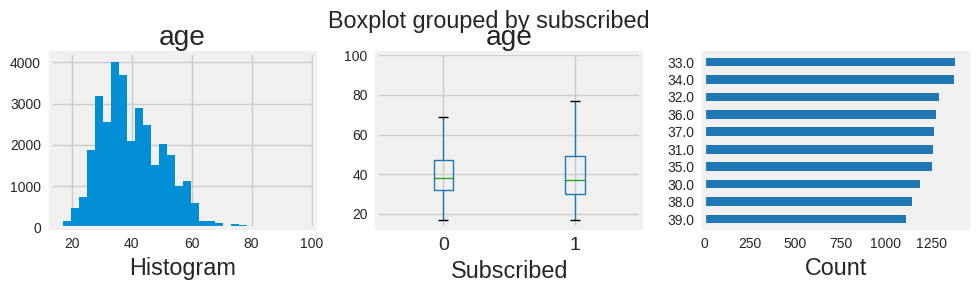

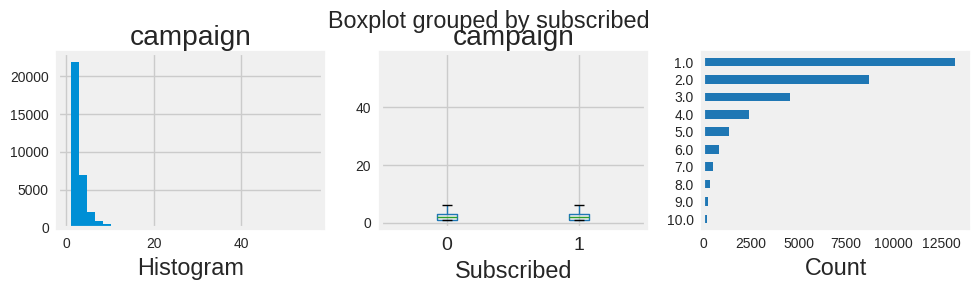

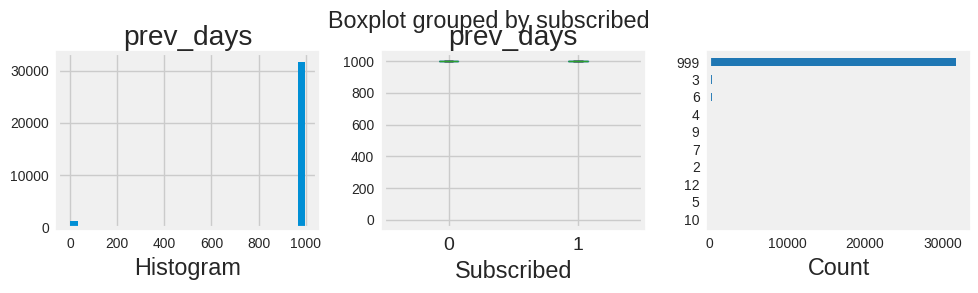

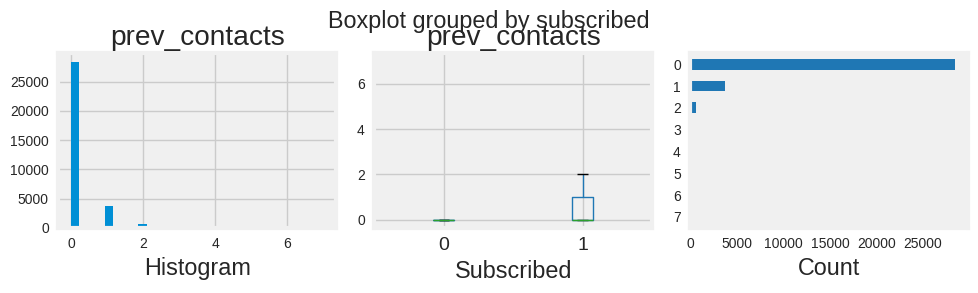

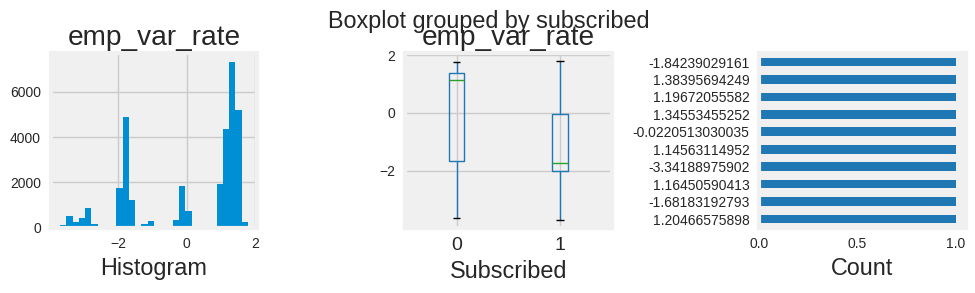

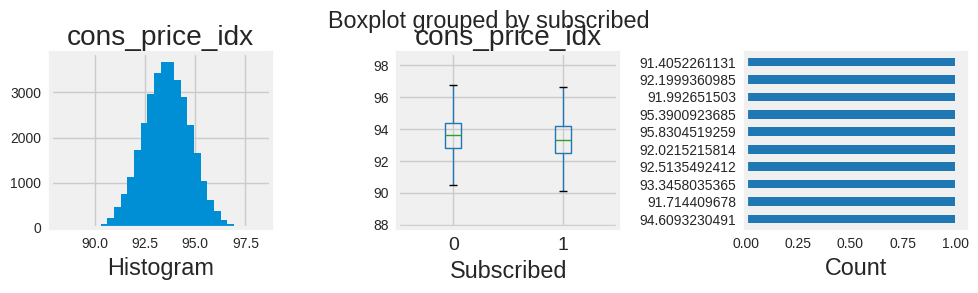

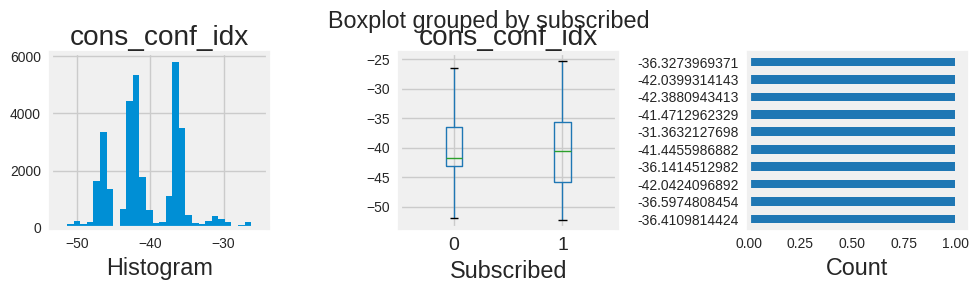

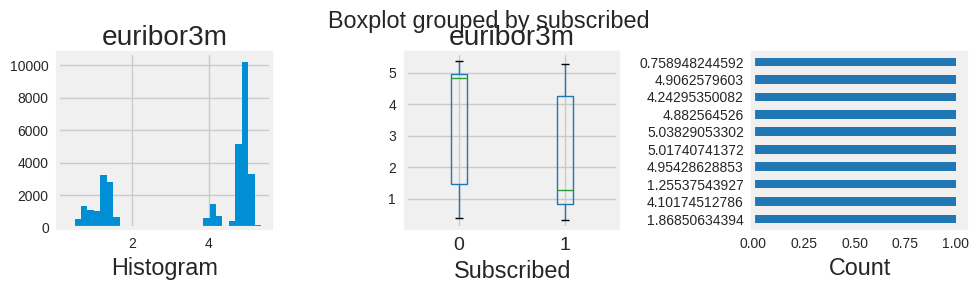

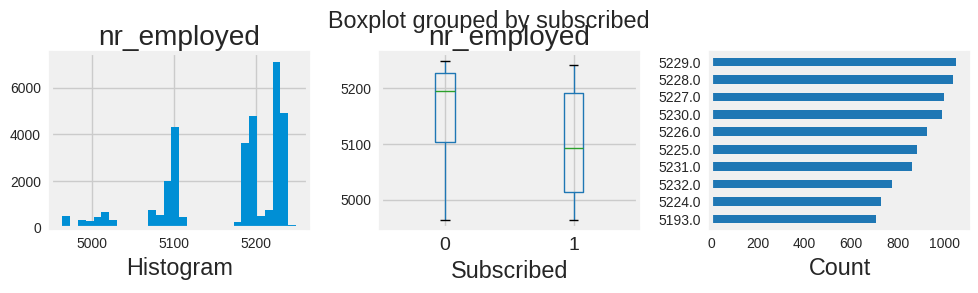

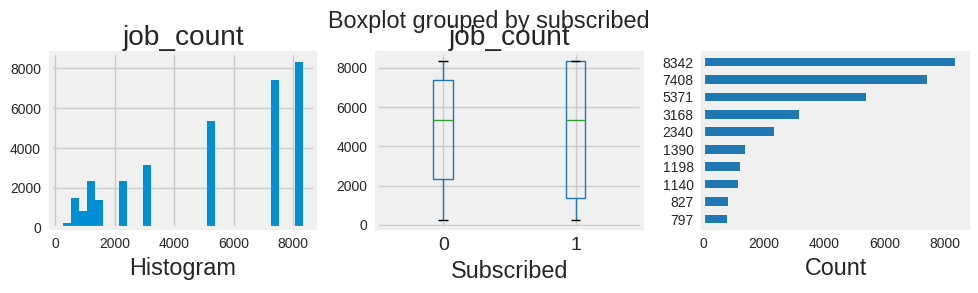

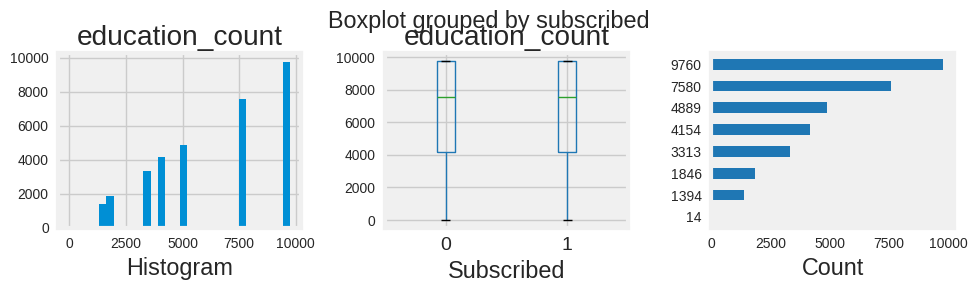

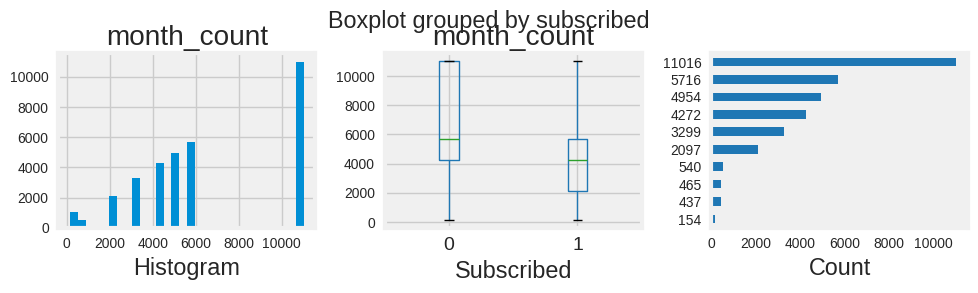

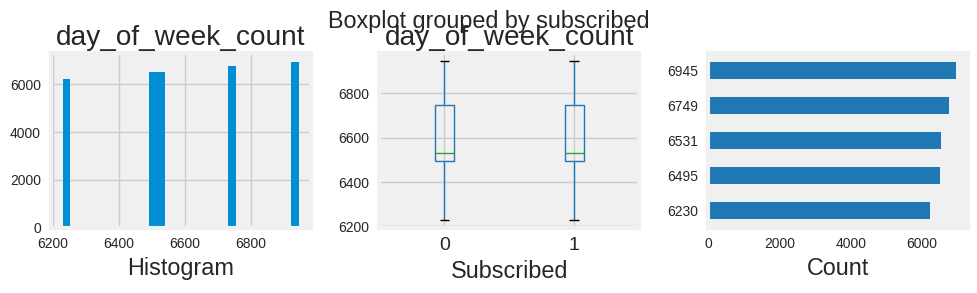

In [19]:
for col in numeric_vars:
    fig, axes = plt.subplots(1, 3,figsize=(10,3))
    ax11 = plt.subplot(1, 3, 1)
    ax21 = plt.subplot(1, 3, 2)
    ax31 = plt.subplot(1, 3, 3)
    fig.suptitle('Feature: %s'%col,fontsize=10)
    visualize_numeric(ax11,ax21,ax31,train,col,target)
    plt.tight_layout()

Feature specific inferences:
1. age
    * a long tail distribution - scaling might be affected by outliers

2. campaign:
    * most of them are contacted once and they probably denied the first time or maybe the call didn't go through properly. Some are contacted 2-5 times which are most likely the ones buying the deposit. There are many outliers again.
    
3. prev_days, prev_contacts:
    * the ones with prev_days = 9999 are the ones not contacted before, which will be covered in the prev_contacts column. so making a new feature doesn't make much sense here
    * since 999 is somewhat represeting an infinite #days, we can play around with this number but it'll not matter for tree-based models and hard to pick for others. So I'll just leave it as it is as there is no clear logic to change it.
    * a new feature campaign+prev_contacts could be tried as it'll represent the total number of times the person has been contacted combining the previous and this campaign.
    
4. socio-economic features:
    * the last 5 features have peculiar multi-model distributions
    * since these are high level aggregate features, they're not likely to help individual predictions. I'll not worry about them atleast for now

Generic inferences:
    * Since there are lot of outliers, using a robustscalar might make more sense
    * polynomial features are not very intuitive here, but can be tried later

#### see what can be done for prev_days

In [20]:
#drop previous days
train.drop('prev_days',axis=1,inplace=True)
holdout.drop('prev_days',axis=1,inplace=True)

In [21]:
numeric_vars = [x for x in numeric_vars if x!='prev_days']

### 1.5 Get PCA and t-SNE for visualization:

PCA requires scaled data but we need not scale the data for both model sets. So we'll use a pipeline here. We saw earlier that data has outliers so we'll use the robust scaler. Its a safe bet because if the data is normal, it'll work similar to standard scaler.

In [22]:
#get vars except target:
x_vars = [x for x in train.columns if x!=target]

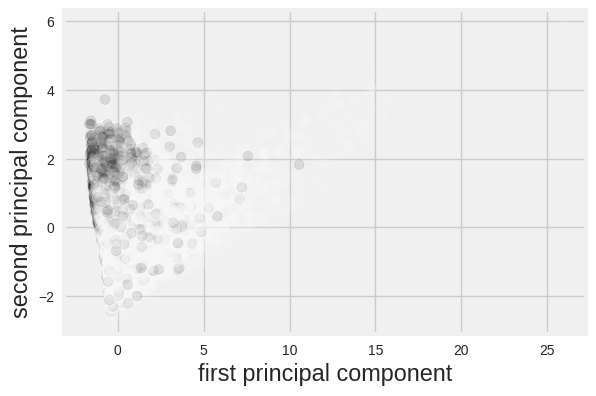

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

pca = make_pipeline(RobustScaler(), PCA(n_components=2))
train_pca = pca.fit_transform(train[x_vars])
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train[target], alpha=.1)
plt.xlabel("first principal component")
plt.ylabel("second principal component")

This looks like a highly non-linear relationship between the data and targets. Both the classes are randomly present in the principal components but there is some concentration on the upper left. 

We could try:
* creating PCA as new features
* feature expansion into the rbf kernel space 

In [24]:
#Add PCA features:
train = pd.concat([train, pd.DataFrame(train_pca,columns=['comp1_pca','comp2_pca'])],axis=1)

#get holdout components:
holdout_pca = pca.transform(holdout[x_vars])
holdout = pd.concat([holdout, pd.DataFrame(holdout_pca,columns=['comp1_pca','comp2_pca'])],axis=1)

#check shape: (2 more columns added)
train.shape, holdout.shape

((32950, 65), (8238, 65))

In [25]:
#add to numeric features:
numeric_vars += ['comp1_pca','comp2_pca']

## Generic Model Functions

Before going into modeling, we'll just define generic functions which will can use to run model and perform cross-validation. This function also has faeture to export predictions on holdout set which can be used to upload them if required, though I'll be using the holdout set directly.

Note that SVC models dont give probabilities by default so we'll use the decision function for the purpose of AUC calculation. The parameter "prob_available" can be used to specify whether the model has "predict_proba" function or not.

In [26]:
#General model function:
from sklearn import model_selection, metrics
def modelfit(alg, dtrain, predictors, performCV=True, print_feature_importance=False, print_coef=False,
             prob_available=True,export_model=False,cv_folds=5,export_name=''):

    #Perform cross-validation:
    if performCV:
        cv_score = model_selection.cross_val_score(alg, dtrain[predictors], dtrain['subscribed'], 
                                                   cv=cv_folds, scoring='roc_auc', n_jobs=-1)
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['subscribed'])
        
    #Predict train set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    if prob_available:
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    else:
        dtrain_predprob = alg.decision_function(dtrain[predictors])
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy (Train) : %.4g" % metrics.accuracy_score(dtrain['subscribed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['subscribed'], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if print_feature_importance:
        plt.figure(figsize=(5, 10))
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values()
        feat_imp.plot(kind='barh', title='Feature Importances')
        plt.xlabel('Feature Importance Score')
        
    #Print Coefficients:
    if print_coef:
        plt.figure(figsize=(5, 10))
        coeff = pd.Series(alg.coef_[-1,:], predictors).sort_values()
        coeff.plot(kind='barh', title='Feature Importances')
        plt.xlabel('Coefficients')
        
    #export model:
    if export_model:
        dexport = dtest[['ID']]
        dexport['subscribed'] = dtest_predprob
        dexport[['ID','subscribed']].to_csv('final_data/%s.csv'%export_name,index=False)

In [27]:
#check on holdout:
def get_holdout_perf(alg, predictors, hold, hold_sol=hold_sol, prob_available=True):
    df = hold[['ID']]
    if prob_available:
        df['ranks'] = alg.predict_proba(hold[predictors])[:,1]
    else:
        df['ranks'] = alg.decision_function(hold[predictors])
        
    df['pred'] = alg.predict(hold[predictors])
    df = df.merge(hold_sol,on='ID')
    print("\nModel Report")
    print("Accuracy (Holdout) : %.4g" % metrics.accuracy_score(df['subscribed'], df['pred']))
    print("AUC Score (Holdout): %f" % metrics.roc_auc_score(df['subscribed'], df['ranks']))

# Step2 - ModelSet1 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set1:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. Any classification algorithm covered in class apart from tree-based models can be tested here.

In [28]:
#copy the data so that model specific feature engineering can be performed.
train_set1 = train.copy()
holdout_set1 = holdout.copy()

Lets just modify the data here itself and not worry about including it as a first step in all pipelines. Also we don't have to scale all the features but just the numeric ones so it'll be more coding to incorporating it into pipeline. We'll not but be able to try different scalings though, which seems fine in this case.

In [29]:
rscaler = RobustScaler()
train_set1[numeric_vars] = rscaler.fit_transform(train[numeric_vars])
holdout_set1[numeric_vars] = rscaler.transform(holdout[numeric_vars])

In [30]:
train_set1[numeric_vars].describe()

,age,campaign,prev_contacts,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job_count,education_count,month_count,day_of_week_count,comp1_pca,comp2_pca
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,3.295000e+04,3.295000e+04,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,0.134604,0.320819,0.174385,-0.325162,-0.002059,1.778918e-01,-3.313144e-01,-0.216537,-0.008051,-0.214175,0.110155,0.267342,0.374670,0.070064
std,0.723387,1.401615,0.498989,0.509025,0.735516,6.951410e-01,4.870591e-01,0.579516,0.468409,0.499353,0.512759,0.953345,1.387879,0.627448
min,-1.400000,-0.500000,0.000000,-1.546750,-3.337028,-1.576539e+00,-1.254724e+00,-1.843200,-0.851383,-1.349625,-0.824733,-1.185039,-1.316918,-1.442994
25%,-0.400000,-0.500000,0.000000,-0.908977,-0.497423,-2.097414e-01,-9.598768e-01,-0.744000,-0.504998,-0.611131,-0.214116,-0.141732,-0.302471,-0.429878
50%,0.000000,0.000000,0.000000,0.000000,0.000000,5.316419e-16,-1.245130e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.600000,0.500000,0.000000,0.091023,0.502577,7.902586e-01,4.012322e-02,0.256000,0.495002,0.388869,0.785884,0.858268,0.697529,0.570122
max,3.933333,27.000000,7.000000,0.226696,2.958154,2.448440e+00,1.575257e-01,0.440000,0.495002,0.388869,0.785884,1.629921,25.588237,3.435310


## 2.1 Feature Selection

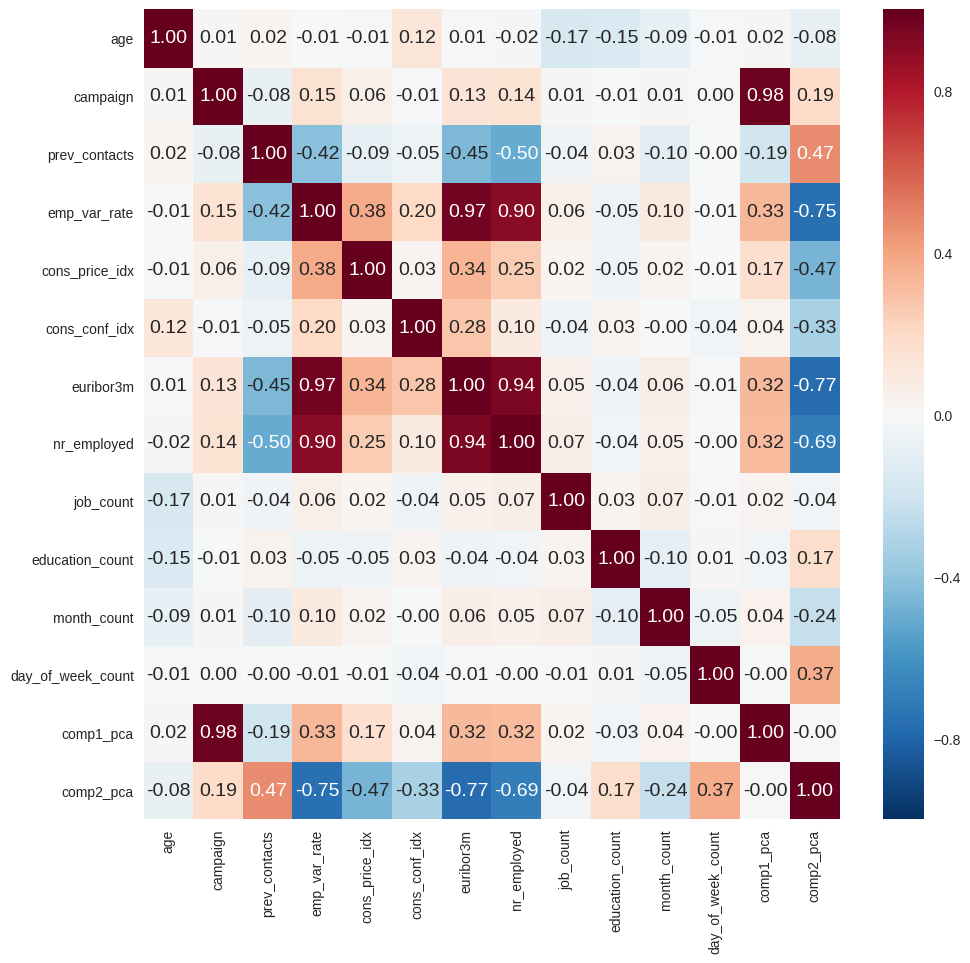

In [31]:
#Lets check correlations:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(train_set1[numeric_vars].corr(),
           annot=True, fmt=".2f")

Here we see high correlations between:
* euribor3m vs emp_var_rate 
* euribor3m vs nr_employed
* nr_employed vs emp_var_rate

So we can just keep nr_employed and drop the other two.

We also notice that the first component of pca is highly correlated with campaign, which seems like the column with maximum variance. So we can remove the first component as well.

In [32]:
#drop columns
train_set1.drop(['euribor3m','emp_var_rate','comp1_pca'],axis=1,inplace=True)
holdout_set1.drop(['euribor3m','emp_var_rate','comp1_pca'],axis=1,inplace=True)

In [33]:
#Lets check the feature importance using f_classif and mutual_info_classif
from sklearn.feature_selection import f_classif, mutual_info_classif

#define xvars:
x_vars = [x for x in train_set1 if x!=target]

f_values, p_values = f_classif(train_set1[x_vars], train_set1[target])
mi_scores = mutual_info_classif(train_set1[x_vars], train_set1[target])

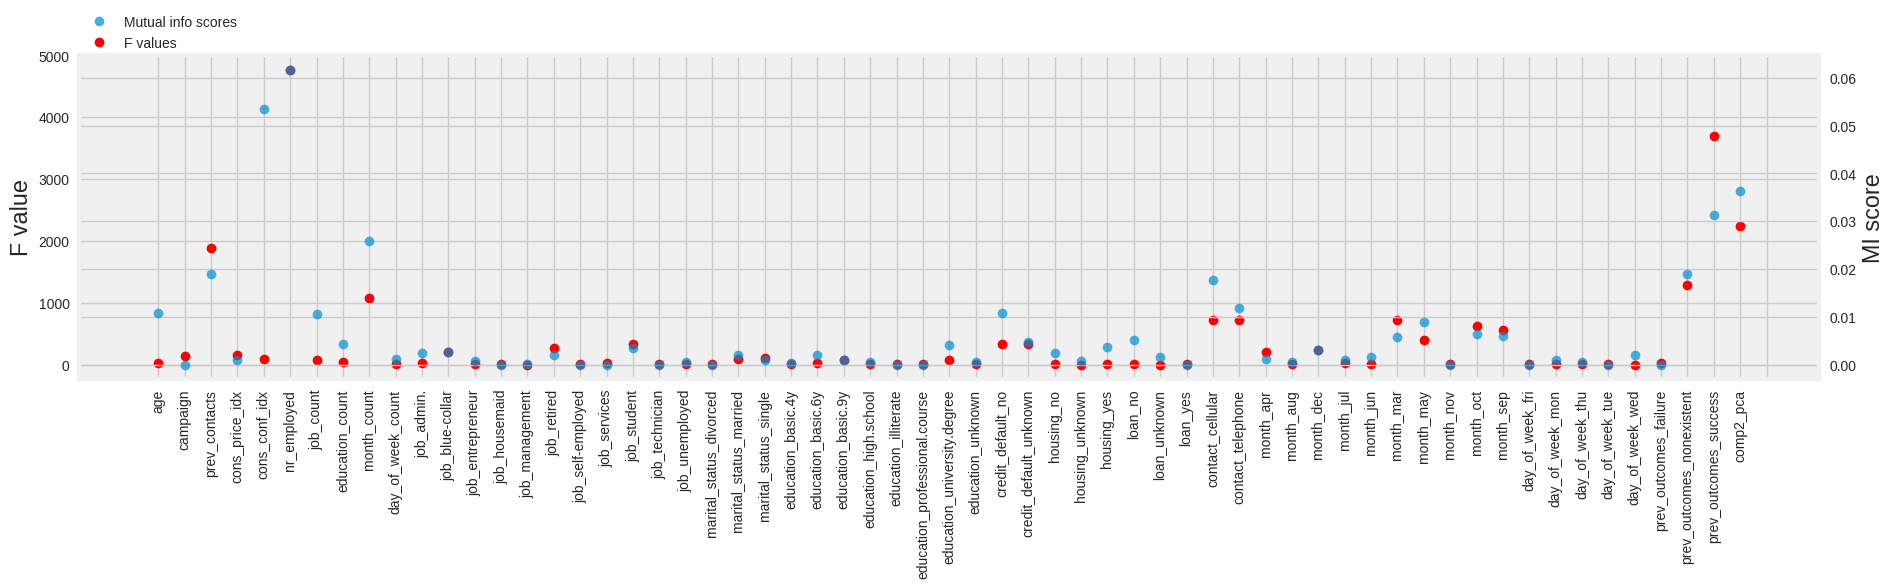

In [34]:
#plot them
fig = plt.figure(figsize=(20, 4))
plt.xticks(range(train_set1.shape[1]), x_vars, rotation='vertical')
line_f, = plt.plot(f_values, 'o', c='r')
plt.ylabel("F value")
ax2 = plt.twinx()
line_s, = ax2.plot(mi_scores, 'o', alpha=.7)
ax2.set_ylabel("MI score")
plt.legend([line_s, line_f], ["Mutual info scores", "F values"], loc=(0, 1))

## 2.2 Logistic Regression
This is more robust to parmeters and we can try something real quick:

In [35]:
#select the predictors
predictors = [x for x in train_set1.columns if x!=target]

In [36]:
from sklearn.linear_model import LogisticRegressionCV
log_reg = LogisticRegressionCV()

#run the model to get best parameter value:
modelfit(log_reg,train_set1,predictors,performCV=False, print_coef=False)


Model Report
Accuracy (Train) : 0.9
AUC Score (Train): 0.793392


In [37]:
#get the best parameter:
log_reg.scores_

{1: array([[ 0.887,  0.889,  0.897,  0.898,  0.898,  0.898,  0.898,  0.898,
          0.898,  0.898],
        [ 0.887,  0.888,  0.898,  0.9  ,  0.9  ,  0.9  ,  0.9  ,  0.9  ,
          0.9  ,  0.9  ],
        [ 0.887,  0.888,  0.897,  0.899,  0.9  ,  0.9  ,  0.9  ,  0.9  ,
          0.9  ,  0.9  ]])}

This shows that the model is very robust to C so we can keep the default value


Model Report
Accuracy (Train) : 0.9
AUC Score (Train): 0.793392
CV Score : Mean - 0.7900929 | Std - 0.005675799 | Min - 0.7828467 | Max - 0.7977526
1 loop, best of 1: 18.1 s per loop


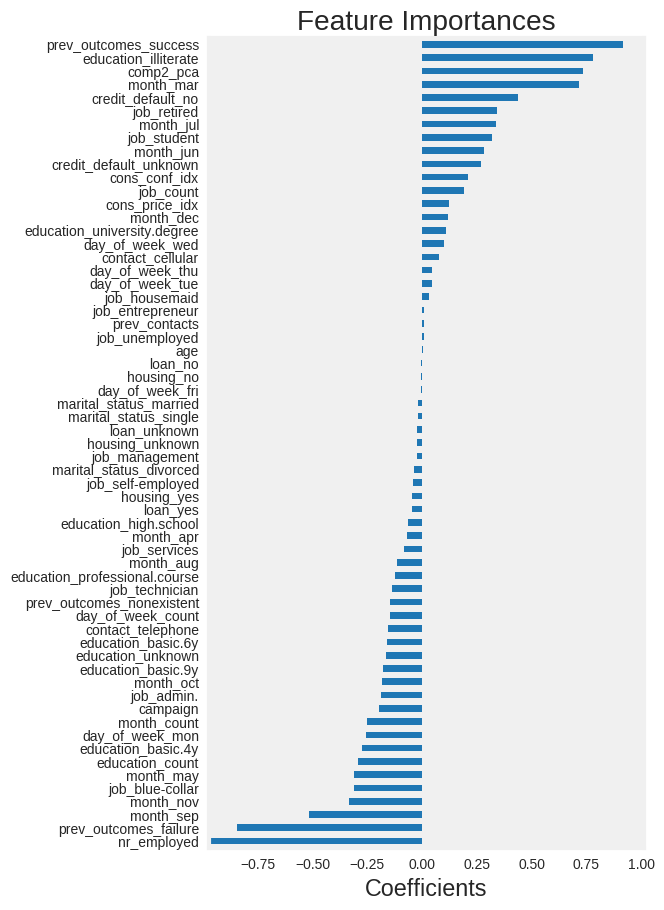

In [38]:
%%timeit -n1 -r1
#get the CV score now:
modelfit(log_reg,train_set1,predictors,performCV=True, print_coef=True)

In [39]:
get_holdout_perf(log_reg,predictors,holdout_set1)


Model Report
Accuracy (Holdout) : 0.8974
AUC Score (Holdout): 0.781213


/home/andy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/andy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 2.2 SVM Models

In [40]:
from sklearn.svm import SVC, LinearSVC

Note that this is a time-consuming operation. I have also added an ipython magic operator here to give you a sense of the time taken by the algorithm to run CV and show results. Since this is too high, we'll use kernel approximation trick as discussed in class to tune parameters.

In [41]:
%%timeit -n1 -r1
svm=SVC(kernel='rbf')
modelfit(svm,train_set1,predictors,performCV=True, prob_available=False)


Model Report
Accuracy (Train) : 0.8973
AUC Score (Train): 0.806512
CV Score : Mean - 0.7167188 | Std - 0.005024333 | Min - 0.7082906 | Max - 0.7226029
1 loop, best of 1: 5min 54s per loop


This seems to be underfitting the data. We need to adjust the gamma values. Lets try the kernel approximation trick and see how much time it takes.

In [42]:
from sklearn.kernel_approximation import RBFSampler

In [43]:
%%timeit -n1 -r1
#Kernel Approximation (one time operation)
gamma = 1./(train_set1.shape[1]*train_set1.as_matrix().std())
num_comp=5000
approx_rbf = RBFSampler(gamma=0.05, n_components=num_comp)
train_rbf = approx_rbf.fit_transform(train_set1[predictors])
train_rbf.shape

1 loop, best of 1: 6.7 s per loop


In [44]:
#create a dataframe for our function:
rbf_cols = [str(x) for x in range(num_comp)]
train_rbf = pd.DataFrame(train_rbf,columns=rbf_cols)
train_rbf['subscribed'] = train_set1['subscribed']

NameError: name 'num_comp' is not defined

In [ ]:
%%timeit -n1 -r1
svc = LinearSVC()
modelfit(svc,train_rbf,rbf_cols,performCV=True, print_coef=False, prob_available=False)

This seems to be underfitting as well. We can try different parameters but it'll be time consuming.

### To run - grid-search on parameters

We see that logistic regression is fast and provides a simple and efficient model.

# Step3 - ModelSet2 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set2:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. We encourage you to try decition tree, random forest and gradient boosted tree methods here and pick the one which you think works best.

## 3.1 Feature Engineering

Now we'll create the features which we thought could be important for the model as per the initial analysis. Note that feature scaling is not required for tree-based models.

In [ ]:
#create new data for this set:
train_set2 = train.copy()
holdout_set2 = holdout.copy()

In [ ]:
#combine basics
def educ_mod(df):
    col = ["education_illiterate","education_basic.4y","education_basic.6y"]
    df['education_basic'] = df[col].apply(sum,axis=1)
    df.drop(col,axis=1,inplace=True)
educ_mod(train_set2)
educ_mod(holdout_set2)

In [ ]:
#combine months:
def month_mod(df):
    col1 = ["month_mar","month_apr","month_may","month_jun","month_jul"]
    col2 = [x for x in df.columns if x.startswith('month') and x not in col1]
    df['month_first_half_new'] = df[col1].apply(sum,axis=1)
    df['month_second_half_new'] = df[col2].apply(sum,axis=1)
month_mod(train_set2)
month_mod(holdout_set2)

In [ ]:
#combine jobs
def educ_mod(df):
    col = ["job_retired","job_student","job_unemployed"]
    df['job_unpaid'] = df[col].apply(sum,axis=1)
educ_mod(train_set2)
educ_mod(holdout_set2)

In [ ]:
train_set2.shape, train_set2.columns

## 3.2 Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
predictors2 = [x for x in train_set2 if x!=target]

In [ ]:
%%timeit -n1 -r1
dt1=DecisionTreeClassifier(min_samples_leaf=50,random_state=2017)
modelfit(dt1,train_set2,predictors2,performCV=True,print_feature_importance=True)

Here we see that there is 1 very improtant variable which is more than 5 times important as the second most important. 
Also, a single tree is not that effective so we'll try random forests now.

## 3.3 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf1 = RandomForestClassifier(n_estimators=100,min_samples_leaf=50,random_state=2017,n_jobs=-1)
modelfit(rf1,train_set2,predictors2,performCV=True,print_feature_importance=True)

Here we see that nr_employed is no more 5x important as compared to second best. Also, features which were less important for decision trees are coming up. This is primarily because of the high correlations we saw previously. Since nr_employed, euribor and emp_var_rate are highly correlated, they are randomly sampled in different iterations and importance is divided. 

Though RF are innert to correlations, we can still remove these so that these variables appear in fewer trees and other variables get a chance to participate in splitting. This may/maynot help but should not hurt the model.

Also, we notice some features with 0 importance. We can remove them as well as they play no role in the trees in which they get selected.

In [ ]:
remove_cols = np.append(np.array(predictors2)[rf1.feature_importances_<=0.001],(['euribor3m','emp_var_rate']))
predictors3 = [x for x in predictors2 if x not in remove_cols]
print(predictors3)

In [ ]:
rf2=RandomForestClassifier(n_estimators=100,min_samples_leaf=50,random_state=2017,n_jobs=-1)
modelfit(rf2,train_set2,predictors3,performCV=True,print_feature_importance=True)

We see slight improvement in the mean but the std also increased a bit probably because of high variability in the trees. We can improve this by making more estimators. But lets tune some parameters first.

We'll be running an extensive search here but we can afford this because RF models run very fast. We are testing 50 models and it takes less than 4 minutes.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# %%timeit -n1 -r1  #if you use this, the variables will not be stored in memory
param = {
    'criterion':['gini','entropy'],
    'min_samples_leaf':range(20,61,10),
    'max_features':range(5,10)
}
gs1 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=100,random_state=2017,n_jobs=-1),
                        param_grid = param, 
                        scoring='roc_auc',
                        n_jobs=-1, iid=False, cv=5)
gs1.fit(train_set2[predictors3],train_set2[target])

In [ ]:
#Lets look at the top 10 results:
cols = ['mean_test_score','std_test_score','param_criterion','param_max_features','param_min_samples_leaf','rank_test_score']
pd.DataFrame(gs1.cv_results_)[cols].sort_values('rank_test_score').head(10)

We saw slight improvement in grid-search. Note that we got 9 max_features as the best model so we should run more search to test higher values. I'll just use this one for now.

Finally, we can make more estimators to reduce the standard deviation of the model and make it more robust.

In [ ]:
rf3=RandomForestClassifier(n_estimators=1000,criterion='entropy',min_samples_leaf=50,
                           max_features=9,random_state=2017,n_jobs=-1)
modelfit(rf3,train_set2,predictors3,performCV=True,print_feature_importance=True)

In [ ]:
#Finally lets check the performance on test set:
get_holdout_perf(rf3,predictors3,holdout_set2)

#### WHy is it worse?

## 3.4 GBM

We'll use the same features as used in RF and tune a GBM.
For tuning guide, refer [here](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/).

Lets fix the learning rate to 0.1 and tune number of estimators for some parameters tuned for RF and subsample of 0.8, which we'll again tune later.

We'll use a different random state than RF here.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
param_test1 = {'n_estimators':range(50,121,10)}
gs1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_leaf=50,
                                                               max_features=9,
                                                               subsample=0.8,
                                                               random_state=101010), 
                        param_grid = param_test1, 
                        scoring='roc_auc', cv=5)
gs1.fit(train_set2[predictors3],train_set2[target])

In [ ]:
cols = ['mean_test_score','std_test_score','param_n_estimators','rank_test_score']
pd.DataFrame(gs1.cv_results_)[cols].sort_values('rank_test_score').head(10)

Its still increasting with n_estimators so we need to try more

In [ ]:
param_test1 = {'n_estimators':range(120,201,10)}
gs1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_leaf=50,
                                                               max_features=9,
                                                               subsample=0.8,
                                                               random_state=101010), 
                        param_grid = param_test1, 
                        scoring='roc_auc', cv=5)
gs1.fit(train_set2[predictors3],train_set2[target])
pd.DataFrame(gs1.cv_results_)[cols].sort_values('rank_test_score').head(10)

So we got 170 estimators. Now we'll tune other parameters usign these estimators. Since the data is small, we can tune many parameters together. But as it grows large, we need to take a call on which ones to tune together.

You would have noticed the high standard deviation of the models. GBM is a high variance model in general and we'll look at a couple of measures of making this more robust later.

In [ ]:
param_test2 = {'max_features':range(8,12), 
               'min_samples_leaf':range(30,61,10),
               'subsample':[x/10 for x in range(6,9)]}
gs2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                          n_estimators=170,
                                                           random_state=101010), 
                        param_grid = param_test2, 
                        scoring='roc_auc', cv=5)
gs2.fit(train_set2[predictors3],train_set2[target])

In [ ]:
cols = ['mean_test_score','std_test_score','param_max_features','param_min_samples_leaf',
        'param_subsample','rank_test_score']
pd.DataFrame(gs2.cv_results_)[cols].sort_values('rank_test_score').head(10)

We can see that the test CV score is improving. But we need to run it again because max feature is on boundary case.

There are 2 ways to enhance performance here:
* Lower the learning rate and tune a higher number of parameters. This'll take longer to run but will make model more robust.
* Run 10 models on different seeds and average the results. If there is high variance in the models, this will lower is to some extent.

Again these are computationally expensive methods and can be done only if feasible.

In [ ]:
#Finally lets check the performance on test set:
get_holdout_perf(gs1.best_estimator_,predictors3,holdout_set2)

In [ ]:
get_holdout_perf(gs2.best_estimator_,predictors3,holdout_set2)

# Step4 - Ensemble [20 points + 10 Bonus points]

In this step, we expect you to use the models created before and create new predictions. You should definitely try poor man's stacking but we encourage you to think of different ensemble techniques as well. We will judge your creativity and improvement in model performance using ensemble models and you can potentially earn 10 bonus points here.

In [ ]:
#create scaled data with features of set 2:
train_set3 = train_set2.copy()
holdout_set3 = holdout_set2.copy()

In [ ]:
from sklearn.preprocessing import RobustScaler
rscaler = RobustScaler()
train_set3[numeric_vars] = rscaler.fit_transform(train_set2[numeric_vars])
holdout_set3[numeric_vars] = rscaler.transform(holdout_set2[numeric_vars])

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import FunctionTransformer

voting = VotingClassifier([('logreg', LogisticRegression()),
                           ('rf', RandomForestClassifier(criterion='entropy',min_samples_leaf=50,
                                           max_features=9)),
                            ('gbm', GradientBoostingClassifier(n_estimators=170, learning_rate=0.1, 
                                                             max_features=8, min_samples_leaf=50, subsample=0.7))],
                         voting='soft')
reshaper = FunctionTransformer(lambda X_: np.rollaxis(X_, 1).reshape(-1, 6)[:, 1::2], validate=False)

predictors = [x for x in train_set3.columns if x!=target]
first_stage = make_pipeline(voting, reshaper)
transform_cv = cross_val_predict(first_stage, train_set3[predictors], train_set3[target], cv=5, method="transform")
second_stage = LogisticRegression().fit(transform_cv, train_set3[target])

# Resampling - Easy Ensemble of RF:

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler

def make_resampled_ensemble(estimator, n_estimators=500):
    estimators = []
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state = i
        pipe = make_imb_pipeline(RandomUnderSampler(random_state=i, replacement=True),
                                 est)
        estimators.append(("est_i".format(i), pipe))
    return VotingClassifier(estimators, voting="soft")

In [ ]:
#use same parameters as rf:
dt_resamp = DecisionTreeClassifier(min_samples_leaf=50,criterion='entropy',max_features=9,random_state=2017)
resampled_dt = make_resampled_ensemble(dt_resamp)

scores = model_selection.cross_val_score(resampled_dt, train_set2[predictors3], train_set2[target], cv=5, scoring='roc_auc')
print(np.mean(scores),np.std(scores))

In [ ]:
resampled_dt.fit(train_set2[predictors3], train_set2[target])
get_holdout_perf(resampled_dt,predictors3,holdout_set2)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg_resamp = LogisticRegression()
resampled_logreg = make_resampled_ensemble(logreg_resamp)

scores = model_selection.cross_val_score(resampled_logreg, train_set3[predictors], train_set3[target], cv=5, scoring='roc_auc')
print(np.mean(scores),np.std(scores))

In [ ]:
resampled_logreg.fit(train_set3[predictors], train_set3[target])
get_holdout_perf(resampled_logreg,predictors,holdout_set3)